In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.legend_handler import HandlerPatch
import xarray as xr
import seaborn as sns
import seaborn_image as isns
import string
import warnings
import calendar
import cmasher as cm
import numpy as np

In [2]:
warnings.filterwarnings('ignore')

In [3]:
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature

In [4]:
plt.style.use('seaborn-pastel')
isns.set_context(mode="notebook", fontfamily="MS PMincho")
sns.set_context(font_scale=0.8)

In [5]:
dataPath = '/Volumes/ccHD/OAEdata/variables/'
varName = ['alkalinity', 'dic', 'fco2', 'co2flux', 'ph', 'somxl010', 'masks']

In [6]:
filePath = {
    'ALK' : {
                'base26' : dataPath + varName[0] + '/base26.nc',
                'oae26' : dataPath + varName[0] + '/oae26.nc',
                'base70' : dataPath + varName[0] + '/base70.nc',
                'oae70' : dataPath + varName[0] + '/oae70.nc'
    },
    'DIC' : {
                'base26' : dataPath + varName[1] + '/base26.nc',
                'oae26' : dataPath + varName[1] + '/oae26.nc',
                'base70' : dataPath + varName[1] + '/base70.nc',
                'oae70' : dataPath + varName[1] + '/oae70.nc'
    },
    'fco2' : {
                'base26' : dataPath + varName[2] + '/base26.nc',
                'oae26' : dataPath + varName[2] + '/oae26.nc',
                'base70' : dataPath + varName[2] + '/base70.nc',
                'oae70' : dataPath + varName[2] + '/oae70.nc'
    },
    'co2flux' : {
                'base26' : dataPath + varName[3] + '/base26.nc',
                'oae26' : dataPath + varName[3] + '/oae26.nc',
                'base70' : dataPath + varName[3] + '/base70.nc',
                'oae70' : dataPath + varName[3] + '/oae70.nc'
    },   
    'ph' : {
                'base26' : dataPath + varName[4] + '/base26.nc',
                'oae26' : dataPath + varName[4] + '/oae26.nc',
                'base70' : dataPath + varName[4] + '/base70.nc',
                'oae70' : dataPath + varName[4] + '/oae70.nc'
    },
}
mldPath = {
    'somxl010' : {
                'base26' : dataPath + varName[5] + '/base26.nc',
                'oae26' : dataPath + varName[5] + '/oae26.nc',
                'base70' : dataPath + varName[5] + '/base70.nc',
                'oae70' : dataPath + varName[5] + '/oae70.nc'
    },
}

pathMesh = dataPath + varName[6] + '/meshMask.nc'
pathTmask = dataPath + varName[6] + '/tmask.nc'

In [7]:
# define functions

In [8]:
class HandlerEllipse(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = mpatches.Ellipse(xy=center, width=height + xdescent,
                             height=height + ydescent)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

In [9]:
# slice variable to mixed layer depth

def slicing(data, mld, var):
    mld_bool = (data.deptht < mld.somxl010).to_dataset(name='mld') 
    data *= mld_bool.mld
    data = data.where(data).fillna(0)

    layers_sum = [
        data[var].isel(deptht=x) * (data.deptht[x] if x == 0 else (data.deptht[x] - data.deptht[x - 1]))
        for x in range(len(data.deptht))
    ]
    
    weighted_var = sum(layers_sum) / mld.somxl010
    return weighted_var

In [10]:
def comp(baseline, oae, var):
    delta = oae - baseline
    return delta

In [11]:
def amplitude(data, var):
    data = data.sel(time_counter=slice(tStart, tStop))
    month_length_baseline = data.time_counter.dt.days_in_month
    
    monthly_data = (data * month_length_baseline).resample(time_counter='M').sum() / month_length_baseline.resample(time_counter='M').sum()
    
    maxD = monthly_data.resample(time_counter='AS').max('time_counter')
    minD = monthly_data.resample(time_counter='AS').min('time_counter')
    amplitude = (maxD - minD)[var].mean(dim='time_counter')
    
    return amplitude

In [12]:
# define figures 

In [13]:
def lineplot(base, oae, delta, axTop, axBot, var):
    line1, = axTop.plot(base[var], '-', linewidth=6, zorder=.2, color='mediumturquoise', label='Baseline')
    line2, = axTop.plot(oae[var], '-', linewidth=6, zorder=.2, color='lightcoral', label='OAE')
    line3, = axBot.plot(delta, '-', linewidth=3, zorder=.2, color='goldenrod', label='Delta')
    axTop.tick_params(axis='both', which='major', labelsize=s)
    axBot.tick_params(axis='both', which='major', labelsize=s)
    return [line1, line2, line3], ['Base', 'OAE', 'Delta']

In [14]:
def scatterplot(base, oae, delta, axTop, axBot, var):
    colors = dict(zip(base.index.unique(), 
                    ['powderblue', 'darkcyan', 'forestgreen', 'darkseagreen', 
                     'honeydew', 'bisque', 'khaki', 'gold', 
                     'sandybrown', 'lightcoral', 'chocolate', 'cadetblue']))
    
    axTop.plot(base[var], '-', color="black", linewidth=0.5, zorder=.2)
    axTop.plot(oae[var], '-', color="black", linewidth=0.5, zorder=.2)
    axTop.scatter(base.index, base[var], color=base.index.map(lambda x: colors[x]), edgecolors='black',  linewidth=0.5, s=100)
    axTop.scatter(oae.index, oae[var], color=oae.index.map(lambda x: colors[x]), edgecolors='black',  linewidth=0.5, s=100)
    axBot.plot(delta[var], '-', color="black", linewidth=0.5, zorder=.2)
    axBot.scatter(delta.index, delta[var], color=delta.index.map(lambda x: colors[x]), edgecolors='black',  linewidth=0.5, s=60)
    axTop.tick_params(axis='y', which='major', labelsize=s)

In [15]:
def fig_plot_map(data, var, ax):
    im = data[var].plot.pcolormesh( 
        ax=ax, 
        x="nav_lon", 
        y="nav_lat",
        cmap=cmap, 
        add_colorbar=False,
        shading='auto'
        )
    return im

In [16]:
colors_bar = [
                    ('J', 'powderblue'), ('F', 'darkcyan'), 
                    ('M', 'forestgreen'), ('A', 'darkseagreen'), 
                    ('M', 'honeydew'), ('J', 'bisque'), 
                    ('J', 'khaki'), ('A', 'gold'), 
                    ('S', 'sandybrown'), ('O', 'lightcoral'), 
                    ('N', 'chocolate'), ('D', 'cadetblue')
                ]

In [17]:
varName = {
                    'ALK' : {'alkalinity' : r'μ mol $\mathregular{kg^{-1}}$'},
                    'DIC' : {'DIC' : r'μ mol $\mathregular{kg^{-1}}$'},
                    'co2flux' : {'$\mathregular{CO_{2}}$ flux' : r'mol $\mathregular{m^{-2} \ yr^{-1}}$'},
                    'fco2' : {'ocean p$\mathregular{CO_{2}}$' : r'μatm'},
               }

In [18]:
tStart, tStop = '2090', '2100'
s, m, l = 12, 16, 20

In [19]:
# if input data is global, slicing is needed with ' data.sel(x=slice(520, 595), y=slice(330, 435)) '

In [21]:
# slice and save for GitHub repository

# def sliceLastDecade(dataset, file_name):
#     dataset = dataset.sel(time_counter=slice(tStart, tStop))
#     output_path = f'/Volumes/ccHD/OAEdata/variables/lastDecade/{file_name}.nc'
#     dataset.to_netcdf(output_path)

# def process_scenario(var, filePath):
#     var_datasets = {
#         scenario: xr.open_dataset(path, decode_times=True).isel(time=0) if var in ['fco2', 'co2flux', 'ph'] else xr.open_dataset(path, decode_times=True)
#         for scenario, path in filePath[var].items()
#     }

#     for scenario, dataset in var_datasets.items():
#         file_name = f"{var}_{scenario}_lastDecade"
#         sliceLastDecade(dataset, file_name)

# process_scenario('ALK', filePath)
# process_scenario('DIC', filePath)
# process_scenario('fco2', filePath)
# process_scenario('co2flux', filePath)
# process_scenario('ph', filePath)

# mld_datasets = {
#     scenario: xr.open_dataset(path, decode_times=True)
#     for scenario, path in mldPath['somxl010'].items()
# }

# for scenario, dataset in mld_datasets.items():
#         file_name = f"mld_{scenario}_lastDecade"
#         sliceLastDecade(dataset, file_name)

In [25]:
def annualavg(data, var):
    data = data.sel(time_counter=slice(tStart, tStop))
    # data.to_netcdf('/Volumes/ccHD/OAEdata/variables/lastDecade/')
    monthLength = data.time_counter.dt.days_in_month
    
    monthly_avg = (data * monthLength).resample(time_counter='M').sum() / monthLength.resample(time_counter='M').sum()
    
    data_df = monthly_avg.to_dataframe(var)
    monthly_means = data_df.groupby(data_df.index.month).mean().reset_index()
    monthly_means['time_counter'] = monthly_means['time_counter'].apply(lambda x: calendar.month_abbr[x])
    if 'time' in monthly_means.columns.values:
        monthly_means = (monthly_means.drop(columns=['time'])).set_index('time_counter')
    else:
        monthly_means = monthly_means.set_index('time_counter')
                         
    return monthly_means

# ocean mask to remove land values 

def oceanArea(pathMesh, pathTmask):
    meshMask = xr.open_dataset(pathMesh)
    tmask = xr.open_dataset(pathTmask).isel(time=0)

    dx, dy = meshMask.e1t, meshMask.e2t
    gridcellArea = dx * dy
    oceanArea = gridcellArea * tmask
    oceanAreaS = oceanArea.sel(x=slice(520, 595), y=slice(330, 435), z=0)
    
    return oceanAreaS

def process_scenario(var, filePath, mldPath):

    var_datasets = {
        scenario: xr.open_dataset(path, decode_times=True).isel(time=0) if var in ['fco2', 'co2flux', 'ph'] else xr.open_dataset(path, decode_times=True)
        for scenario, path in filePath[var].items()
    }
    mld_datasets = {
        scenario: xr.open_dataset(path, decode_times=True)
        for scenario, path in mldPath['somxl010'].items()
    }

    processed_datasets = {}
    for scenario, dataset in var_datasets.items():
        if var in ['ALK', 'DIC']:
            datasetMLD = mld_datasets[scenario]
            processed_datasets[scenario] = slicing(dataset, datasetMLD, var)
        elif var in ['co2flux']:
            processed_datasets[scenario] = dataset[var] * 31536000 / 0.04401
        else:
            processed_datasets[scenario] = dataset[var]

    return processed_datasets

def calculate_lineplot(processed_datasets, oceanAreaS, var):
    coordsPoint = [58, 60, 41, 43]

    regridded_scenario = {}
    sliced_datapoint = {}

    for scenario_key, scenario in processed_datasets.items():
        sliced_data = scenario.isel(x=slice(coordsPoint[0], coordsPoint[1]), y=slice(coordsPoint[2], coordsPoint[3]))
        sliced_datapoint[scenario_key] = sliced_data.mean(['x', 'y'])
        scenario_oce = scenario * oceanAreaS['tmask']
        regridded = scenario_oce.sum(['x', 'y']) / oceanAreaS['tmask'].sum(['x', 'y'])
        regridded_scenario[scenario_key] = regridded.isel(t=0)

    return regridded_scenario, sliced_datapoint

def processingAVG(scenarios, var):
    year_scenario = {scenario_key: annualavg(scenario, var) for scenario_key, scenario in scenarios.items()}

    delta_scenario = {
        scenario_key: comp(year_scenario[scenario_key], year_scenario[oae_key], var)
        for scenario_key in year_scenario
        if scenario_key.startswith('base') and (oae_key := scenario_key.replace('base', 'oae')) in year_scenario
    }

    return year_scenario, delta_scenario

def processingLINEPLOT(var, filePath, mldPath):
    processed_datasets = process_scenario(var, filePath, mldPath)
    oceanAreaS = oceanArea(pathMesh, pathTmask)
    regridded_scenario, sliced_datapoint = calculate_lineplot(processed_datasets, oceanAreaS, var)
    finalEU = processingAVG(regridded_scenario, var)
    finalP = processingAVG(sliced_datapoint, var)
    return finalEU, finalP

In [26]:
def plot_style(axes, varName, l, m, s):
    for n, ax in enumerate([axes[i] for i in range(0, 24, 2)]):
        ax.text(0.89, 0.40, f"{string.punctuation[7]}{string.ascii_lowercase[n]}{string.punctuation[8]}",
            transform=ax.transAxes, size=l, color='black', fontweight="bold")

    for location in ['left', 'bottom', 'right', 'top']:
        for ax in axes:
            ax.spines[location].set_linewidth(0.4)

    for ax in [axes[16], axes[18], axes[20], axes[22]]:
        ax.axhline(0, color='black', linewidth=0.5)

    for ax in axes:
        if ax in [axes[0], axes[4]]:
            ax.set_ylabel(f"{list(varName['ALK'].keys())[0]} [{list(varName['ALK'].values())[0]}]", fontsize=m, labelpad=s)
        elif ax in [axes[1], axes[5]]:
            ax.set_ylabel(f"Δ {list(varName['ALK'].keys())[0]}", fontsize=m, labelpad=s)
        elif ax in [axes[8], axes[12]]:
            ax.set_ylabel(f"{list(varName['fco2'].keys())[0]} [{list(varName['fco2'].values())[0]}]", fontsize=m, labelpad=s)
        elif ax in [axes[9], axes[13]]:
            ax.set_ylabel(f"Δ {list(varName['fco2'].keys())[0]}", fontsize=m, labelpad=s)
        elif ax in [axes[16], axes[20]]:
            ax.set_ylabel(f"{list(varName['co2flux'].keys())[0]} [{list(varName['co2flux'].values())[0]}]", fontsize=m, labelpad=s)
        elif ax in [axes[17], axes[21]]:
            ax.set_ylabel(f"Δ {list(varName['co2flux'].keys())[0]}", fontsize=m, labelpad=s)

        if ax in [axes[2], axes[3], axes[6], axes[7], axes[10], axes[11], axes[14], axes[15], axes[18], axes[19], axes[22], axes[23]]:
            ax.yaxis.set_tick_params(labelleft=False)

    axes[0].set_title("European avg - SSP1-2.6", fontsize=l, y=1.02)
    axes[2].set_title("European avg - SSP3-7.0", fontsize=l, y=1.02)
    axes[4].set_title("Point S - SSP1-2.6", fontsize=l, y=1.02)
    axes[6].set_title("Point S - SSP3-7.0", fontsize=l, y=1.02)

In [50]:
euALK, psALK = processingLINEPLOT('ALK', filePath, mldPath)
euDIC, psDIC = processingLINEPLOT('DIC', filePath, mldPath)
euPCO2, psPCO2 = processingLINEPLOT('fco2', filePath, mldPath)
euCO2flux, psCO2flux = processingLINEPLOT('co2flux', filePath, mldPath)
euPH, psPH = processingLINEPLOT('ph', filePath, mldPath)

In [36]:
# gs0 = gridspec.GridSpec(6, 2, hspace=0.08)

# axes = []

# fig = plt.figure(figsize=(22, 42)) 

# for i in range(6):
#     gs = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[i], height_ratios=[1, 0.4], width_ratios=[1, 1], hspace=0, wspace=0)
    
#     ax1 = fig.add_subplot(gs[0, 0])
#     ax2 = fig.add_subplot(gs[1, 0])
#     ax3 = fig.add_subplot(gs[0, 1], sharey=ax1)
#     ax4 = fig.add_subplot(gs[1, 1], sharey=ax2)
    
#     axes.extend([ax1, ax2, ax3, ax4])
    
# for i, (data, line_type) in enumerate([(alkalinityLINE, 'ALK'), (pco2LINE, 'fco2'), (co2fluxLINE, 'co2flux')]):
#     for j in range(2):
#         plot_lineplot([
#             list(data[j][0].values())[0:4:2],  # x-data
#             list(data[j][0].values())[1:4:2],  # y-data
#             list(data[j][1].values())[0:2],    # additional data
#         ], axes[8*i + 4*j:8*i + 4*(j+1)], line_type)

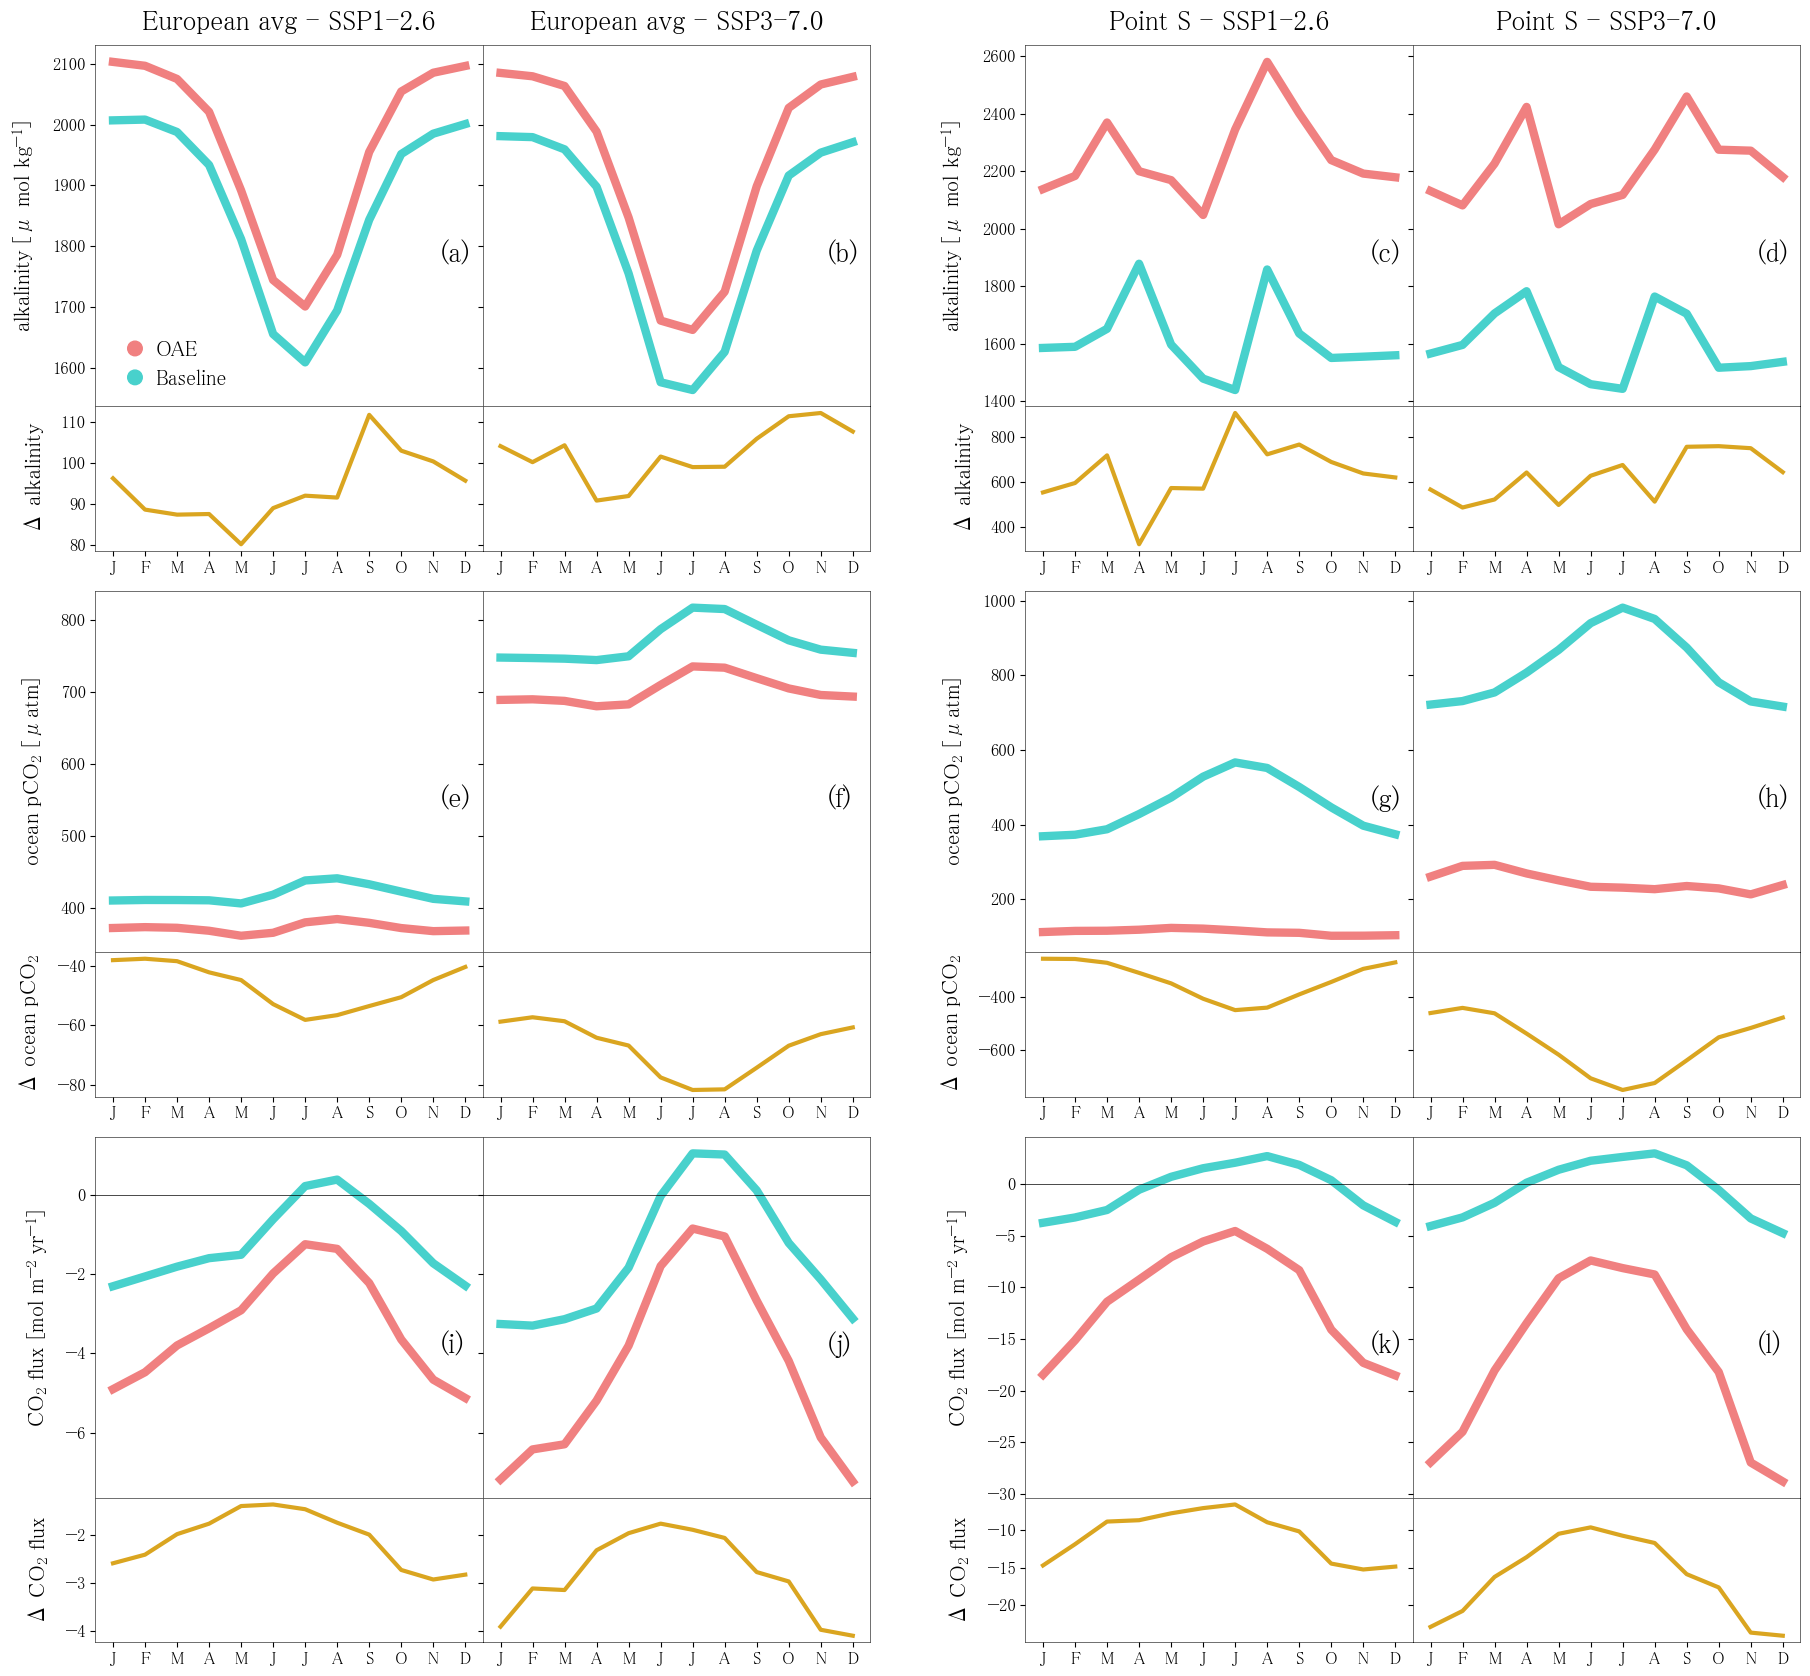

In [68]:
gs0 = gridspec.GridSpec(6, 2, hspace=0.08)

axes = []

fig = plt.figure(figsize=(22, 42)) 

for i in range(6):
    gs = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[i], height_ratios=[1, 0.4], width_ratios=[1, 1], hspace=0, wspace=0)
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[0, 1], sharey=ax1)
    ax4 = fig.add_subplot(gs[1, 1], sharey=ax2)
    
    axes.extend([ax1, ax2, ax3, ax4])
    
lineplot(list(euALK[0].values())[0], list(euALK[0].values())[1], list(euALK[1].values())[0], axes[0], axes[1], 'ALK') # eu26
lineplot(list(euALK[0].values())[2], list(euALK[0].values())[3], list(euALK[1].values())[1], axes[2], axes[3], 'ALK') # eu70
lineplot(list(psALK[0].values())[0], list(psALK[0].values())[1], list(psALK[1].values())[0], axes[4], axes[5], 'ALK') # ls26
lineplot(list(psALK[0].values())[2], list(psALK[0].values())[3], list(psALK[1].values())[1], axes[6], axes[7], 'ALK') # ls70

lineplot(list(euPCO2[0].values())[0], list(euPCO2[0].values())[1], list(euPCO2[1].values())[0], axes[8], axes[9], 'fco2') # eu26
lineplot(list(euPCO2[0].values())[2], list(euPCO2[0].values())[3], list(euPCO2[1].values())[1], axes[10], axes[11], 'fco2') # eu70
lineplot(list(psPCO2[0].values())[0], list(psPCO2[0].values())[1], list(psPCO2[1].values())[0], axes[12], axes[13], 'fco2') # ls26
lineplot(list(psPCO2[0].values())[2], list(psPCO2[0].values())[3], list(psPCO2[1].values())[1], axes[14], axes[15], 'fco2') # ls70

lineplot(list(euCO2flux[0].values())[0], list(euCO2flux[0].values())[1], list(euCO2flux[1].values())[0], axes[16], axes[17], 'co2flux') # eu26
lineplot(list(euCO2flux[0].values())[2], list(euCO2flux[0].values())[3], list(euCO2flux[1].values())[1], axes[18], axes[19], 'co2flux') # eu70
lineplot(list(psCO2flux[0].values())[0], list(psCO2flux[0].values())[1], list(psCO2flux[1].values())[0], axes[20], axes[21], 'co2flux') # ls26
lineplot(list(psCO2flux[0].values())[2], list(psCO2flux[0].values())[3], list(psCO2flux[1].values())[1], axes[22], axes[23], 'co2flux') # ls70

labels = ['OAE', 'Baseline']
colors = ['lightcoral', 'mediumturquoise']

patches = [mpatches.Circle((0.5, 0.5), 0.1, color=color, label=label) for label, color in zip(labels, colors)]

handles, labels = zip(*[(p, p.get_label()) for p in patches])
axes[0].legend(handles=handles, labels=labels, frameon=False, handletextpad=0.01, handler_map={mpatches.Circle: HandlerEllipse()}) 

for ax in axes:
    y = list(range(0,13))
    ax.set_xticks(np.arange(min(y), max(y), 1))
    labels_lat = [item.get_text() for item in ax.get_xticklabels()]
    lat_label = ['J','F','M','A','M','J','J','A','S','O','N','D']
    ax.set_xticklabels(lat_label, fontsize=s)
    ax.set_ylabel("")
    
def add_text(ax, texts):
    for x, y, s in texts:
        ax.text(x, y, s=s, fontsize=m)
        
odd_ax = [axes[i] for i in range(0, 24, 2)]
    
plot_style(axes, varName, l, m, s)
    
plt.savefig('/Users/chiaraciscato/Desktop/GEOMAR/OAEseasonality/out/lineplot.png')

pass

In [ ]:
# different lineplot style

gs0 = gridspec.GridSpec(6, 2, hspace=0.05)

axes = []

fig = plt.figure(figsize=(22, 42)) 

s=12
m=16
l=20

for i in range(6):
    gs = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[i], height_ratios=[1, 0.4], width_ratios=[1, 1], hspace=0, wspace=0)
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[0, 1], sharey=ax1)
    ax4 = fig.add_subplot(gs[1, 1], sharey=ax2)
    
    axes.extend([ax1, ax2, ax3, ax4])
    
im1 = scatterplot(list(alkalinityLINE[0][0].values())[0], list(alkalinityLINE[0][0].values())[1], list(alkalinityLINE[0][1].values())[0], axes[0], axes[1], 'ALK')
im2 = scatterplot(list(alkalinityLINE[0][0].values())[2], list(alkalinityLINE[0][0].values())[3], list(alkalinityLINE[0][1].values())[1], axes[2], axes[3], 'ALK')
im3 = scatterplot(list(alkalinityLINE[1][0].values())[0], list(alkalinityLINE[1][0].values())[1], list(alkalinityLINE[1][1].values())[0], axes[4], axes[5], 'ALK')
im4 = scatterplot(list(alkalinityLINE[1][0].values())[2], list(alkalinityLINE[1][0].values())[3], list(alkalinityLINE[1][1].values())[1], axes[6], axes[7], 'ALK')

scatterplot(list(pco2LINE[0][0].values())[0], list(pco2LINE[0][0].values())[1], list(pco2LINE[0][1].values())[0], axes[8], axes[9], 'fco2')
scatterplot(list(pco2LINE[0][0].values())[2], list(pco2LINE[0][0].values())[3], list(pco2LINE[0][1].values())[1], axes[10], axes[11], 'fco2')
scatterplot(list(pco2LINE[1][0].values())[0], list(pco2LINE[1][0].values())[1], list(pco2LINE[1][1].values())[0], axes[12], axes[13], 'fco2')
scatterplot(list(pco2LINE[1][0].values())[2], list(pco2LINE[1][0].values())[3], list(pco2LINE[1][1].values())[1], axes[14], axes[15], 'fco2')

scatterplot(list(co2fluxLINE[0][0].values())[0], list(co2fluxLINE[0][0].values())[1], list(co2fluxLINE[0][1].values())[0], axes[16], axes[17], 'co2flux')
scatterplot(list(co2fluxLINE[0][0].values())[2], list(co2fluxLINE[0][0].values())[3], list(co2fluxLINE[0][1].values())[1], axes[18], axes[19], 'co2flux')
scatterplot(list(co2fluxLINE[1][0].values())[0], list(co2fluxLINE[1][0].values())[1], list(co2fluxLINE[1][1].values())[0], axes[20], axes[21], 'co2flux')
scatterplot(list(co2fluxLINE[1][0].values())[2], list(co2fluxLINE[1][0].values())[3], list(co2fluxLINE[1][1].values())[1], axes[22], axes[23], 'co2flux')
        
alk_text_settings = [
    (axes[0], [(0, 1950, 'Baseline'), (3, 2070, 'OAE')]),
    (axes[2], [(0, 1915, 'Baseline'), (3, 2050, 'OAE')]),
    (axes[4], [(0, 1800, 'Baseline'), (0, 2400, 'OAE')]),
    (axes[6], [(0, 1850, 'Baseline'), (0, 2350, 'OAE')])
]

pco2_text_settings = [
    (axes[8], [(0, 450, 'Baseline'), (0, 320, 'OAE')]),
    (axes[10], [(0, 780, 'Baseline'), (0, 630, 'OAE')]),
    (axes[12], [(0, 450, 'Baseline'), (0, 200, 'OAE')]),
    (axes[14], [(0, 850, 'Baseline'), (0, 450, 'OAE')])
]

co2flux_text_settings = [
    (axes[16], [(0, -1.5, 'Baseline'), (0, -3.6, 'OAE')]),
    (axes[18], [(0, -2, 'Baseline'), (0, -6, 'OAE')]),
    (axes[20], [(0, 1, 'Baseline'), (0, -13, 'OAE')]),
    (axes[22], [(0, 1, 'Baseline'), (0, -19, 'OAE')])
]

for ax, texts in alk_text_settings + pco2_text_settings + co2flux_text_settings:
    add_text(ax, texts)

legend =[mpatches.Circle((0.5, 0.5), 1, facecolor=color, edgecolor="black", linewidth=0.5, label=month, alpha=1) for month, color in colors_bar]
axes[0].legend(handles = legend, bbox_to_anchor=(.92,1.45), loc='best', columnspacing=.7, handletextpad=.5, fontsize=m, ncol = 4, handler_map={mpatches.Circle: HandlerEllipse()})

def add_text(ax, texts):
    for x, y, s in texts:
        ax.text(x, y, s=s, fontsize=m)

plot_style(axes, varName, l, m, s)

for ax in axes:
    ax.set_xticks([])
    ax.set_xticklabels([])

plt.savefig('/Users/chiaraciscato/Desktop/GEOMAR/OAEseasonality/out/scatterplot.png')

pass

In [ ]:
def processingMAP(var):
    var_datasets = {
        scenario: (
            xr.open_dataset(path, decode_times=True).isel(time=0) if var in ['fco2', 'co2flux','ph'] else xr.open_dataset(path, decode_times=True)
        )
        for scenario, path in filePath[var].items()
    }
    mld_datasets = {
        scenario: (
            xr.open_dataset(path, decode_times=True)
        )
        for scenario, path in mldPath['somxl010'].items()
    }

    # datasets for maps 

    processed_datasets = {}
    map_datasets = {}

    for scenario, dataset in var_datasets.items():
        if var in ['ALK', 'DIC']:
            depth_slice = slicing(dataset, mld_datasets[scenario], [var])
            amplitude_var = amplitude(depth_slice, [var])
        elif var == 'co2flux':
            dataUnit = (dataset[var] * 31536000 / 0.04401).to_dataset(name=var)
            amplitude_var = amplitude(dataUnit, [var])
        else:
            amplitude_var = amplitude(dataset, [var])

        amplitude_var = amplitude_var.where(amplitude_var)  # Mask invalid data
        map_datasets[scenario] = amplitude_var

    return map_datasets

In [ ]:
alkalinityMAP = processingMAP('ALK')
dicMAP = processingMAP('DIC')
fco2MAP = processingMAP('fco2')
co2fluxMAP = processingMAP('co2flux')
phMAP = processingMAP('ph')

In [ ]:
cmap = cm.prinsenvlag_r

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(23, 16))
plt.subplots_adjust(wspace=0.07, hspace=0.05)

plt.rcParams['axes.linewidth'] = .2

s=14
m=18

im1=fig_plot_map(list(alkalinityMAP.values())[1]-list(alkalinityMAP.values())[0], 'ALK', ax1)
fig_plot_map(list(fco2MAP.values())[1]-list(fco2MAP.values())[0], 'fco2', ax2)
im2=fig_plot_map(list(co2fluxMAP.values())[1]-list(co2fluxMAP.values())[0], 'co2flux', ax3)
fig_plot_map(list(alkalinityMAP.values())[3]-list(alkalinityMAP.values())[2], 'ALK', ax4)
fig_plot_map(list(fco2MAP.values())[3]-list(fco2MAP.values())[2], 'fco2', ax5)
fig_plot_map(list(co2fluxMAP.values())[3]-list(co2fluxMAP.values())[2], 'co2flux', ax6)

axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for ax in axes:
    ax.coastlines()
    ax.set_extent([-25, 14.5, 37.5, 70])
    ax.add_feature(cfeature.LAND, zorder=100, facecolor='whitesmoke', edgecolor='black', linewidth=.05)
    ax.plot(3, 53, "o", color='black', markersize=8)
    ax.text(0.5, 54,'point S', fontsize=s, color='black')

y = list(range(45,70))
x = list(range(-27,9))
    
for ax in axes: 
    if ax == ax1 or ax == ax4:
        ax.set_yticks(np.arange(min(y), max(y)+1, 5))
        labels_lat = [item.get_text() for item in ax.get_yticklabels()]
        lat_label = ['45°N', '50°N', '55°N', '60°N', '65°N']
        ax.set_yticklabels(lat_label, fontsize=m)
        ax.set_ylabel("Latitude")
    if ax == ax4 or ax == ax5 or ax == ax6:
        ax.set_xticks(np.arange(min(x)+7, max(x)+1, 5))
        labels_lon = [item.get_text() for item in ax.get_xticklabels()]
        lon_label = ['20°W', '15°W', '10°W', '5°W', '0°', '5°E']
        ax.set_xticklabels(lon_label, fontsize=m)
        ax.set_xlabel('Longitude')
    if ax == ax1:
        ax.set_title(f"Δ {list(varName['ALK'].keys())[0]} [{list(varName['ALK'].values())[0]}]", fontsize=m, y=1.2)
    elif ax == ax2:
        ax.set_title(f"Δ {list(varName['fco2'].keys())[0]} [{list(varName['fco2'].values())[0]}]", fontsize=m, y=1.2),
    elif ax == ax3:
        ax.set_title(f"Δ {list(varName['co2flux'].keys())[0]} [{list(varName['co2flux'].values())[0]}]", fontsize=m, y=1.2),
    else:
        ax.set_title("")
        
for n, ax in enumerate(axes):
    ax.text(0.88, 0.9, string.punctuation[7] + string.ascii_lowercase[n] + string.punctuation[8],
            transform=ax.transAxes, size=l, weight='bold', color='black')

cbar1 = fig.colorbar(im1, ax = [ax1, ax4, ax2, ax5], aspect = 40, pad=0.02, location='top')
cbar2 = fig.colorbar(im2, ax = [ax3, ax6], aspect = 20, pad=0.02, location='top')

cbars = [cbar1, cbar2]
    
for cbar in cbars:
    cbar.ax.set_frame_on(False)
    if cbar == cbar1:
        cbar.ax.tick_params(labelsize=s)
    elif cbar == cbar2:
        cbar.ax.yaxis.get_offset_text().set(size=s)
        cbar.ax.tick_params(labelsize=s)
    else:
        cbar.ax.yaxis.get_offset_text().set(size=s)
        cbar.ax.tick_params(labelsize=s)
        
pass

plt.savefig('/Users/chiaraciscato/Desktop/GEOMAR/OAEseasonality/out/map.png')

In [ ]:
def csequestration(pathData, var, pathMesh, pathTmask):
    oceanAreaS = oceanArea(pathMesh, pathTmask).isel(t=0)
    var_datasets = {
        scenario: xr.open_dataset(path, decode_times=True) for scenario, path in pathData[var].items()
    }
    
    year_scenario = {}
    
    for scenario_key, scenario in var_datasets.items():
        scenario = (oceanAreaS.tmask * scenario).sel(time_counter=slice(tStart, tStop)) * 31536000 / 3.6667 * 1e-12
        days_in_month = scenario.time_counter.dt.days_in_month
        scenario = ((scenario * days_in_month).resample(time_counter='M').sum() / days_in_month.resample(time_counter='M').sum())
        scenario = scenario.where(scenario)
        scenario = scenario.mean(dim='time_counter')
        year_scenario[scenario_key] = scenario.isel(time=0)
        
    delta_scenario = {}
    
    delta_scenario = {
        scenario_key: -(comp(year_scenario[scenario_key], year_scenario[oae_key], var))
        for scenario_key in year_scenario
            if scenario_key.startswith('base') and (oae_key := scenario_key.replace('base', 'oae')) in year_scenario
        }
    return year_scenario, delta_scenario

In [ ]:
csequEff = csequestration(filePath, 'co2flux', pathMesh, pathTmask)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 6))
plt.subplots_adjust(wspace=0.07, hspace=0.05)

im = fig_plot_map(list(csequEff[1].values())[0], 'co2flux', ax1)
fig_plot_map(list(csequEff[1].values())[1], 'co2flux', ax2)

for ax in [ax1,ax2]:
    ax.tick_params(axis='both', which='major', labelsize=s)
    ax.set_title('')
    ax.coastlines()
    ax.set_extent([-25, 14.5, 37.5, 70])
    ax.add_feature(cfeature.LAND, zorder=100, facecolor='whitesmoke', edgecolor='black', linewidth=.05)
    ax.plot(3, 53, "o", color='black', markersize=4)
    ax.text(0.5, 54,'point S', fontsize=s, color='black')

cbar = plt.colorbar(im, ax=[ax1,ax2], aspect = 24, pad=0.04, location='bottom', cmap=cmap)
cbar.set_label('[Gt $\mathregular{yr^{-1}}$]', fontsize=s)
cbar.ax.set_frame_on(False)

fig.suptitle('Carbon sequestration efficiency in SSP1-2.6 (left) and SSP3-7.0 (right)', fontsize=s)

for t in cbar.ax.get_xticklabels():
     t.set_fontsize(s)
        
pass

plt.savefig('/Users/chiaraciscato/Desktop/GEOMAR/OAEseasonality/out/cEfficiency.png')